In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')

In [2]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

In [68]:
#no preprocessing - therefore, do not see why I would need a pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

forest = RandomForestClassifier(n_jobs=-1, random_state=0)

param_grid = {'n_estimators':[10,20,30,40,50,60,100],
              'max_depth':[1,2,4,6,8,10]}

X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [69]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MUT_RESISTANCE']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [70]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [71]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [72]:
#grid search with shuffled kfold validation
KFold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=KFold_shuffle)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=2, n_estimators=40, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6607989464442493
grid_kfold_shuffle: test set average accuracy:  0.6754385964912281 



In [73]:
from matplotlib import pyplot as plt
import numpy as np

#define and fit forests with best performing parameters, or default parameters
forest_best_params = RandomForestClassifier(max_depth=2, n_estimators=40, n_jobs=-1, random_state=0)
forest_no_params = RandomForestClassifier(random_state=0)
forest_best_params.fit(X_train_cv, y_train_cv)    
forest_no_params.fit(X_train_cv, y_train_cv)

#plot charts
def plot_feature_importances(model):
    n_features = features[:,1:].shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[3:])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('feautre importance plot')

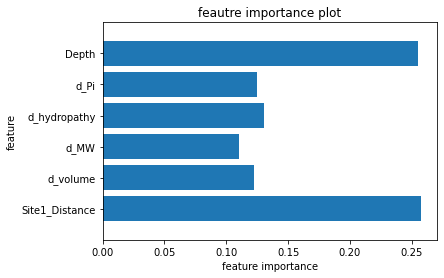

In [74]:
plot_feature_importances(forest_no_params)

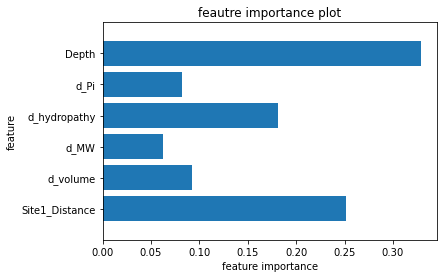

In [75]:
plot_feature_importances(forest_best_params)

In [76]:
#grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7197178401085547
grid_kfold_shuffle test set average precision:  0.7170235413587019 



In [77]:
#grid search with shuffled kfold validation
#use predict_prob a function ot calculate ROC AUC

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7166932881036001
grid_kfold_shuffle test set AUC:  0.7626231527093597 



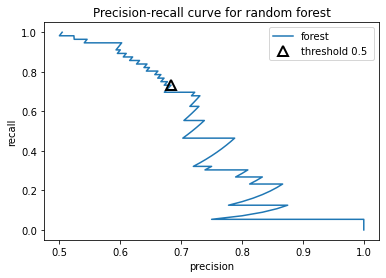

In [78]:
#precision recall curve for best average precision estimator
#max_depth=8, n_estimators=40

from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

forest = RandomForestClassifier(max_depth=4, n_estimators=40, random_state=0)
forest.fit(X_train_cv, y_train_cv)

precision, recall, thresholds = precision_recall_curve(y_test_cv, forest.predict_proba(X_test_cv)[:, 1])

plt.plot(precision, recall, label='forest')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k', 
          markersize=10, label='threshold 0.5 ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision-recall curve for random forest')
plt.legend(loc='best')

Text(0.5, 1.0, 'ROC curve for random forest')

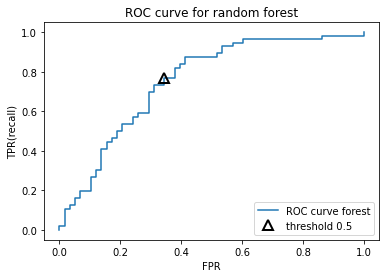

In [79]:
# parameters for best AUC: 
from sklearn.metrics import roc_curve

forest = RandomForestClassifier(max_depth=8, n_estimators=40, random_state=0)
forest.fit(X_train_cv, y_train_cv)

fpr, tpr, thresholds = roc_curve(y_test_cv, forest.predict_proba(X_test_cv)[:, 1])

plt.plot(fpr, tpr, label='ROC curve forest')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10, label='threshold 0.5', 
         fillstyle='none', c='k', mew=2)
plt.legend(loc=4)
plt.title('ROC curve for random forest')